In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import scipy.stats

import scipy as sp;
from numpy.random import multinomial as multi;
from numpy.random import laplace as Lap;

In [2]:
def chi2(n):
    a = 2*n[0] + n[1]; b = 2*n[3] + n[4]
    R = 2*(n[0]+n[1]+n[2]); S = 2*(n[3]+n[4]+n[5])
    N = R+S
    
    return (N*((a*S-b*R)**2))/(R*S*(a+b)*(N-a-b))

In [3]:
# pseudo_SHD

def pseudo_SHD(n):
    a = 2*n[0] + n[1]; b = 2*n[3] + n[4]
    c = n[1] + 2*n[2]; d = n[4] + 2*n[5]
    
    return (math.fabs(a-b)+math.fabs(c-d))/4

In [4]:
# simple Permute-and-Flip (Algorithm 2)

def PnF(score, m, K,epsilon):
    y = np.zeros(K)
    z = np.zeros(m)
    for i in range(m):
        z[i] = score[i]
    
    for j in range(K):
        q = max(z[0:m-j])
        l = np.zeros(m-j)
        for i in range(m-j):
            l[i] = i
        random.shuffle(l)
        
        for i in range(m-j):
            p = math.exp((epsilon*(z[int(l[i])]-q))/(2*K))
            if(random.random()<=p):
                y[j] = int(l[i])
                for t in range(int(y[j]),m-j-1):
                    z[t] = z[t+1]
                break
    
    for j in range(1,K):
        yy = np.zeros(j)
        for i in range(j):
            yy[i] = y[i]
        yy.sort()
        for i in range(j):
            if y[j] >= yy[i]:
                y[j] += 1
    return y

In [5]:
# (Efficient) Joint Permute-and-Flip

def JointPnF(score, m, K, epsilon):
    S = np.zeros(K)
    SS = np.zeros(K)
    w = np.zeros(m)
    
    si = np.argsort(-score)
    c = np.zeros(m)
    for i in range(m):
        c[si[i]] = i
    ss = sorted(score, reverse=True)
    for i in range(K-1,m):
        if i == K-1:
            C = 1
        else:
            C = (C/(i-K+1)) * i
        r = np.random.rand()
        if r**(1/C)==1:
            D = C
            p = 16
            while(1):
                D /= 10
                p += 1
                if r**(1/D) != 1:
                    l = (1 - r**(1/D))*(10**16)
                    break
            x = -(2/epsilon)*(math.log(l) + (-1*p)*math.log(10))
        else:
            x = -(2/epsilon)*math.log(1-r**(1/C))
        w[i] = ss[i] + x
    SS[K-1] = np.argmax(w[K-1:m]) + K-1
    SS[0:K-1] = np.random.choice(int(SS[K-1]), size=K-1, replace=False)
    
    for i in range(K):
        S[i] = c[int(SS[i])]
    
    return S

In [6]:
def generate_data(N, M):
    S = np.zeros(M)
    b = np.zeros(M)
    c = np.zeros(M)
    n = np.zeros((M,6))
    
    for i in range(M-10):
        n[i][0] = np.random.binomial(int(N/2),1/3)
        n[i][1] = np.random.binomial((int(N/2)-n[i][0]), 1/2)
        n[i][2] = int(N/2)-n[i][0]-n[i][1]
        n[i][3] = np.random.binomial(int(N/2),1/3)
        n[i][4] = np.random.binomial((int(N/2)-n[i][3]), 1/2)
        n[i][5] = int(N/2)-n[i][3]-n[i][4]
    
    for i in range(M-10,M):
        n[i][0] = np.random.binomial(int(N/2),1/7)
        n[i][1] = np.random.binomial((int(N/2)-n[i][0]), 1/4)
        n[i][2] = int(N/2)-n[i][0]-n[i][1]
        n[i][3] = np.random.binomial(int(N/2),1/2)
        n[i][4] = np.random.binomial((int(N/2)-n[i][3]), 1/1.5)
        n[i][5] = int(N/2)-n[i][3]-n[i][4]
    
    return n

In [7]:
def evaluation(K, N, M):
    accuracy = np.zeros((7,2))
    b = np.zeros(M)
    c = np.zeros(M)
    stats = np.zeros(M)
    
    correct = np.zeros((7,2))
    
    for j in range(50):
        n = generate_data(N,M)
        
        for i in range(M):
            stats[i] = chi2(n[i])
            
        EXACT = np.zeros(M)
        PSEUDO = np.zeros(M)
        
        x = np.argsort(-stats)
        
        cc = 19.5
        
        for i in range(M):
            a = int(x[i])
            r0 = int(n[a][0]); r1 = int(n[a][1]); r2 = int(n[a][2])
            s0 = int(n[a][3]); s1 = int(n[a][4]); s2 = int(n[a][5])
            k = [r0,r1,r2,s0,s1,s2]
            PSEUDO[i] = pseudo_SHD(k)
    
        for i in range(7):
            pseudo_shd = PSEUDO
            shd = EXACT
            if K == 7:
                PnF_result = PnF(pseudo_shd,M,K,i+3.7)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+3.7)
            if K == 5:
                PnF_result = PnF(pseudo_shd,M,K,i+2.5)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+2.5)
            if K == 3:
                PnF_result = PnF(pseudo_shd,M,K,i+1.5)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+1.5)
            if K == 1:
                PnF_result = PnF(pseudo_shd,M,K,i+1.0)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+1.0)
            for k in range(K):
                if PnF_result[k] < K:
                    correct[i][0] += 1
                if JointPnF_result[k] < K:
                    correct[i][1] += 1
                
    accuracy = correct/(50*K)
    return accuracy

[[0.59714286 0.56      ]
 [0.80857143 0.90285714]
 [0.87714286 0.93142857]
 [0.90857143 0.93428571]
 [0.89714286 0.95142857]
 [0.91714286 0.94285714]
 [0.91428571 0.95714286]]
[[0.58857143 0.59714286]
 [0.77714286 0.93142857]
 [0.87714286 0.94571429]
 [0.91714286 0.94571429]
 [0.92       0.95428571]
 [0.93714286 0.94857143]
 [0.93142857 0.96      ]]
[[0.63142857 0.65714286]
 [0.80285714 0.87428571]
 [0.86857143 0.90571429]
 [0.90571429 0.94285714]
 [0.91428571 0.96285714]
 [0.92       0.96285714]
 [0.94       0.96571429]]
[[0.56285714 0.56857143]
 [0.76285714 0.92857143]
 [0.88285714 0.94      ]
 [0.88       0.94857143]
 [0.91714286 0.95142857]
 [0.93428571 0.96571429]
 [0.92571429 0.94857143]]
[[0.58571429 0.64857143]
 [0.78       0.91428571]
 [0.88571429 0.94857143]
 [0.90857143 0.95714286]
 [0.92285714 0.97142857]
 [0.92857143 0.97142857]
 [0.92285714 0.97428571]]
[[0.59314286 0.60628571]
 [0.78628571 0.91028571]
 [0.87828571 0.93428571]
 [0.904      0.94571429]
 [0.91428571 0.95828

Text(0, 0.5, 'accuracy')

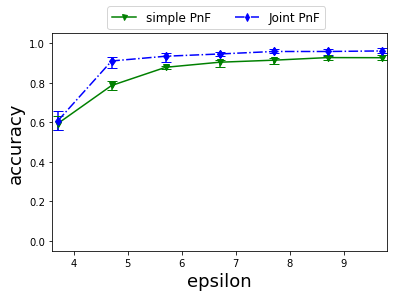

In [8]:
# n = 150, M = 5000
# K = 7

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2)); min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,2))

for j in range(5):
    accuracy = evaluation(7,150,5000)
    for i in range(7):
        epsilon[i] = i+3.7
        for k in range(2):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(2):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(3.6, 9.8)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='v', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="v", markersize=5, color = "green", linestyle = "-", label = "simple PnF")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Joint PnF")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)

[[0.508 0.492]
 [0.792 0.844]
 [0.836 0.844]
 [0.86  0.864]
 [0.9   0.928]
 [0.892 0.944]
 [0.876 0.932]]
[[0.48  0.496]
 [0.756 0.808]
 [0.808 0.88 ]
 [0.844 0.892]
 [0.868 0.932]
 [0.872 0.936]
 [0.888 0.932]]
[[0.496 0.46 ]
 [0.756 0.772]
 [0.784 0.84 ]
 [0.876 0.876]
 [0.864 0.908]
 [0.904 0.9  ]
 [0.888 0.916]]
[[0.524 0.544]
 [0.744 0.88 ]
 [0.848 0.884]
 [0.864 0.936]
 [0.908 0.952]
 [0.928 0.936]
 [0.936 0.952]]
[[0.52  0.516]
 [0.764 0.828]
 [0.82  0.88 ]
 [0.84  0.924]
 [0.908 0.912]
 [0.944 0.936]
 [0.936 0.94 ]]
[[0.5056 0.5016]
 [0.7624 0.8264]
 [0.8192 0.8656]
 [0.8568 0.8984]
 [0.8896 0.9264]
 [0.908  0.9304]
 [0.9048 0.9344]]


Text(0, 0.5, 'accuracy')

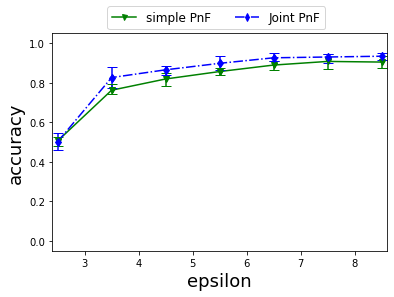

In [9]:
# n = 150, M = 5000
# K = 5

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2)); min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,2))

for j in range(5):
    accuracy = evaluation(5,150,5000)
    for i in range(7):
        epsilon[i] = i+2.5
        for k in range(2):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(2):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(2.4, 8.6)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='v', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="v", markersize=5, color = "green", linestyle = "-", label = "simple PnF")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Joint PnF")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)

[[0.49333333 0.55333333]
 [0.74       0.77333333]
 [0.74666667 0.83333333]
 [0.83333333 0.87333333]
 [0.86       0.90666667]
 [0.88       0.92666667]
 [0.9        0.95333333]]
[[0.47333333 0.48666667]
 [0.74       0.74666667]
 [0.81333333 0.84      ]
 [0.78       0.84      ]
 [0.85333333 0.93333333]
 [0.88666667 0.90666667]
 [0.93333333 0.92666667]]
[[0.43333333 0.46666667]
 [0.76666667 0.70666667]
 [0.80666667 0.83333333]
 [0.92       0.89333333]
 [0.86666667 0.91333333]
 [0.9        0.93333333]
 [0.89333333 0.92666667]]
[[0.4        0.5       ]
 [0.74       0.76666667]
 [0.78666667 0.77333333]
 [0.83333333 0.88666667]
 [0.86       0.87333333]
 [0.89333333 0.9       ]
 [0.91333333 0.93333333]]
[[0.4        0.41333333]
 [0.76666667 0.76      ]
 [0.78666667 0.83333333]
 [0.83333333 0.84666667]
 [0.9        0.88666667]
 [0.88       0.92666667]
 [0.93333333 0.9       ]]
[[0.44       0.484     ]
 [0.75066667 0.75066667]
 [0.788      0.82266667]
 [0.84       0.868     ]
 [0.868      0.90266

Text(0, 0.5, 'accuracy')

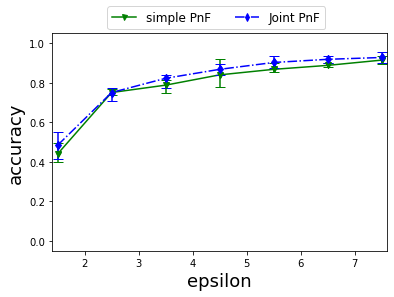

In [10]:
# n = 150, M = 5000
# K = 3

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2)); min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,2))

for j in range(5):
    accuracy = evaluation(3,150,5000)
    for i in range(7):
        epsilon[i] = i+1.5
        for k in range(2):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(2):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(1.4, 7.6)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='v', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="v", markersize=5, color = "green", linestyle = "-", label = "simple PnF")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Joint PnF")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)

[[0.7  0.66]
 [0.78 0.82]
 [0.82 0.9 ]
 [0.9  0.92]
 [0.92 0.92]
 [0.9  0.92]
 [0.92 0.96]]
[[0.62 0.72]
 [0.8  0.88]
 [0.94 0.9 ]
 [0.88 0.9 ]
 [0.98 0.92]
 [0.96 0.98]
 [0.94 0.98]]
[[0.58 0.6 ]
 [0.86 0.88]
 [0.88 0.88]
 [0.96 0.94]
 [0.96 0.88]
 [0.96 1.  ]
 [0.92 0.94]]
[[0.68 0.8 ]
 [0.94 0.84]
 [0.92 0.94]
 [0.96 0.98]
 [0.98 0.96]
 [0.98 0.96]
 [0.98 1.  ]]
[[0.68 0.64]
 [0.8  0.86]
 [0.78 0.94]
 [0.92 0.92]
 [0.86 0.94]
 [0.96 0.9 ]
 [0.96 0.96]]
[[0.652 0.684]
 [0.836 0.856]
 [0.868 0.912]
 [0.924 0.932]
 [0.94  0.924]
 [0.952 0.952]
 [0.944 0.968]]


Text(0, 0.5, 'accuracy')

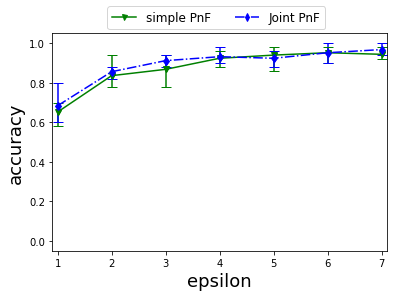

In [11]:
# n = 150, M = 5000
# K = 1

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2)); min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,2))

for j in range(5):
    accuracy = evaluation(1,150,5000)
    for i in range(7):
        epsilon[i] = i+1.0
        for k in range(2):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(2):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(0.9, 7.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='v', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="v", markersize=5, color = "green", linestyle = "-", label = "simple PnF")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Joint PnF")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)